In [1]:
from TCFile import TCFile
import numpy as np
import matplotlib.pyplot as plt
import napari

In [72]:
import os
import numpy as np
import imageio  # pip install imageio
from TCFile import TCFile

def preprocess_and_save_to_png(
    tcf_paths,
    output_dir,
    time_indices_live=(0, 1),
    time_indices_dead=(35, 36),
    mode='qpi',
    crop_size=(480, 480),  # change to the size you want,
    patch_num = None
):
    """
    Preprocess 3D tomography data from TCF files, create a 2D projection,
    crop into tiles (no overlap), and save each tile as an 8-bit PNG.

    Args:
        tcf_paths (list of str): Paths to TCF files.
        output_dir (str): Directory to save output subfolders ('live', 'dead').
        time_indices_live (tuple): Time indices for 'live' label.
        time_indices_dead (tuple): Time indices for 'dead' label.
        mode (str): 'qpi' (sum across z) or 'mip' (max intensity projection).
        crop_size (tuple): (crop_height, crop_width) for each tile.
    """

    # Create output subdirectories for each label
    live_dir = os.path.join(output_dir, "live")
    dead_dir = os.path.join(output_dir, "dead")
    os.makedirs(live_dir, exist_ok=True)
    os.makedirs(dead_dir, exist_ok=True)

    for path in tcf_paths:
        print(f"Processing file: {path}")

        # Open the TCF file in '3D' mode
        tcf_file = TCFile(path, '3D')

        # Process the 'live' time indices
        for t_idx in time_indices_live:
            # data_3d has shape (z, y, x)
            data_3d = tcf_file[t_idx]

            # 2D projection (sum or max)
            if mode.lower() == 'qpi':
                slice_2d = np.sum(data_3d, axis=0)  # shape: (y, x)
            elif mode.lower() == 'mip':
                slice_2d = np.max(data_3d, axis=0)
            else:
                raise ValueError(f"Unknown mode: {mode}")

            # Crop the 2D slice
            _crop_and_save(slice_2d, live_dir, path, t_idx, mode, crop_size, patch_num)

        # Process the 'dead' time indices
        for t_idx in time_indices_dead:
            data_3d = tcf_file[t_idx]
            
            if mode.lower() == 'qpi':
                slice_2d = np.sum(data_3d, axis=0)
            elif mode.lower() == 'mip':
                slice_2d = np.max(data_3d, axis=0)
            else:
                raise ValueError(f"Unknown mode: {mode}")

            _crop_and_save(slice_2d, dead_dir, path, t_idx, mode, crop_size, patch_num)


def _crop_and_save(slice_2d, out_dir, file_path, time_idx, mode, crop_size, patch_num):
    """
    Given a 2D array (slice_2d), split it into non-overlapping
    tiles (of size crop_size) and save each tile as PNG.
    """

    crop_h, crop_w = crop_size
    height, width = slice_2d.shape

    base_name = os.path.splitext(os.path.basename(file_path))[0]

    # Number of vertical/horizontal steps (discard remainder if it doesn't fit exactly)
    num_steps_y = height // crop_h
    num_steps_x = width // crop_w

    # For each tile
    patch_step = 0
    for iy in range(num_steps_y):
        for ix in range(num_steps_x):
            top = iy * crop_h
            left = ix * crop_w
            patch = slice_2d[top:top+crop_h, left:left+crop_w]

            # Min-max normalization (float64 -> uint8)
            min_val, max_val = patch.min(), patch.max()
            if max_val - min_val < 1e-10:
                norm_patch = np.zeros_like(patch, dtype=np.uint8)
            else:
                norm_patch = ((patch - min_val) / (max_val - min_val) * 255).astype(np.uint8)

            # Construct output filename
            # Example: "file_t{0}_y0_x0_mode-mip.png"
            """
            out_name = (
                f"{base_name}_t{time_idx}"
                f"_y{iy}_x{ix}"
                f"_mode-{mode}.png"
            )
            """
            out_name = (
                str(time_idx).zfill(2) + ".png"
            )
            out_path = os.path.join(out_dir, out_name)

            # Save the tile
            imageio.imwrite(out_path, norm_patch)
            
            patch_step += 1

            if patch_step == patch_num :
                break
        if patch_step == patch_num :
                break

# -----------------------------
# Example usage:
# -----------------------------
# Example TCF paths
tcf_paths = [
    r"C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\230510.174730.HeLa_Hoechst.001.Group1.A2.T001P25.TCF"
]
output_directory = r"C:\rkka_Projects\cell_death_v1\Data\test"

preprocess_and_save_to_png(
    tcf_paths,
    output_dir=output_directory,
    time_indices_live=(i for i in range(18)),
    time_indices_dead=(i+18 for i in range(18)),
    mode='mip',        # or 'mip'
    crop_size=(480, 480),  # adjust as needed
    patch_num= 1
)


Processing file: C:\rkka_Projects\cell_death_v1\Data\Hela_Segmentation_test_PWS\TCF\230510.174730.HeLa_Hoechst.001.Group1.A2.T001P25.TCF


In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import numpy as np

# Augmentation Transform
augmentation_transform_2d = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=90),
])

class ImageDatasetWithAugmentation(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=True, rescale=True, gaussian=False):
        """
        Args:
            root_dir (str): Path to the root directory containing 'live' and 'dead' subfolders.
            transform (callable, optional): Additional preprocessing or transforms.
            augmentation (bool): Whether to apply data augmentation.
            rescale (bool): Whether to rescale image intensities to [0, 1].
            gaussian (bool): Whether to apply Gaussian blur.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.augmentation = augmentation
        self.rescale = rescale
        self.gaussian = gaussian

        self.samples = []
        self.labels = []

        # Collect file paths and labels
        for label, class_name in enumerate(['dead', 'live']):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                if filename.endswith('.png'):
                    self.samples.append(os.path.join(class_dir, filename))
                    self.labels.append(label)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load the image
        img_path = self.samples[idx]
        image = Image.open(img_path).convert('L')  # Load as grayscale

        # Convert to numpy array
        image_np = np.array(image)

        # Rescale
        if self.rescale:
            image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())

        # Convert to tensor and expand to 3 channels
        image_tensor = torch.from_numpy(image_np).float().unsqueeze(0).repeat(3, 1, 1)

        # Gaussian blur
        if self.gaussian:
            image_tensor = T.GaussianBlur(kernel_size=(5, 5))(image_tensor)

        # Data augmentation
        if self.augmentation:
            edge_mean = calculate_edge_mean_2d(image_tensor)
            image_tensor = augmentation_transform_2d(image_tensor)
            image_tensor[image_tensor == 0] = edge_mean

        # Additional transforms
        if self.transform:
            image_tensor = self.transform(image_tensor)

        label = torch.tensor(self.labels[idx]).long()
        return image_tensor, label


def calculate_edge_mean_2d(tensor):
    """Calculate mean of edges for a tensor (used in augmentation)."""
    return torch.mean(
        torch.cat([tensor[:, 0, :], tensor[:, -1, :], tensor[:, :, 0], tensor[:, :, -1]])
    )


In [2]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet101
from torchvision import models
from torch import nn, optim
from torchvision.transforms import Normalize
from torch_tomogram_dataset import AugmentedDatasetWrapper

# Dataset Parameters
train_data_dir = r"C:\rkka_Projects\cell_death_v1\Data\output\train"
val_data_dir = r"C:\rkka_Projects\cell_death_v1\Data\output\val"
batch_size = 32
num_epochs = 20
learning_rate = 1e-4

# Dataset and DataLoader
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()
train_dataset = ImageDatasetWithAugmentation(root_dir=train_data_dir, transform=transform, augmentation=True)
val_dataset = ImageDatasetWithAugmentation(root_dir=val_data_dir, transform=transform, augmentation=False)

# Augment wrapping
train_dataset = AugmentedDatasetWrapper(train_dataset, num_repeats=3)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Load EfficientNetV2
model = resnet101(pretrained=True)  # Use EfficientNetV2-Small
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)  # Binary classification (live/dead)
)

for name, param in model.named_parameters():
    if 'layer4.2' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

model = model.cuda()

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [4]:
model = resnet101(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)
)

for name, param in model.named_parameters():
    if 'layer4.2' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
        
model = model.cuda()
        
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\miniconda3\envs\cell\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(10):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Calculate loss and back propagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds==labels).sum().item()

In [66]:
# Count total and trainable parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")

Total Parameters: 42,504,258
Trainable Parameters: 4,466,690


In [50]:

from tqdm import tqdm

# Training Loop
for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        train_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += len(labels)

    val_loss, val_correct, val_total = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.cuda(), labels.cuda()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += len(labels)
    print(
        f"Epoch {epoch+1}/{num_epochs}, "
        f"Train Loss: {train_loss/train_total:.4f}, Train Acc: {train_correct/train_total:.4f}, "
        f"Val Loss: {val_loss/val_total:.4f}, Val Acc: {val_correct/val_total:.4f}"
    )


  5%|▌         | 1/20 [00:09<02:55,  9.22s/it]

Epoch 1/20, Train Loss: 0.0012, Train Acc: 0.9870, Val Loss: 0.0005, Val Acc: 0.9900


 10%|█         | 2/20 [00:18<02:44,  9.13s/it]

Epoch 2/20, Train Loss: 0.0004, Train Acc: 0.9980, Val Loss: 0.0009, Val Acc: 0.9900


 15%|█▌        | 3/20 [00:27<02:34,  9.08s/it]

Epoch 3/20, Train Loss: 0.0005, Train Acc: 0.9950, Val Loss: 0.0010, Val Acc: 0.9900


 20%|██        | 4/20 [00:36<02:26,  9.13s/it]

Epoch 4/20, Train Loss: 0.0003, Train Acc: 0.9990, Val Loss: 0.0010, Val Acc: 0.9900


 20%|██        | 4/20 [00:39<02:36,  9.77s/it]


KeyboardInterrupt: 

In [26]:
c, preds = torch.max(outputs, 1)
preds

tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
        0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')

In [29]:
torch.nn.functional.softmax(outputs)[2]

C:\Users\김민욱\AppData\Local\Temp\ipykernel_1664\3266578923.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.nn.functional.softmax(outputs)[2]


tensor([0.0317, 0.9683], device='cuda:0', grad_fn=<SelectBackward0>)

In [4]:
import torch
torch.save('qpi_model.pth', model.state_dict)

NameError: name 'model' is not defined

In [73]:
model.eval()  # Set model to evaluation mode
model = model.cuda()

# Transform for input preprocessing
transform = models.ResNet101_Weights.IMAGENET1K_V2.transforms()

# Folder containing timelapse PNG images
test_folder = r"C:\rkka_Projects\cell_death_v1\Data\test"

# Ensure the files are sorted by their names
file_list = sorted([f for f in os.listdir(test_folder) if f.endswith('.png')])

# List to store death probabilities
death_probabilities = []

# Predict death probabilities for sorted PNG files
with torch.no_grad():  # Disable gradient computation
    for filename in file_list:
        file_path = os.path.join(test_folder, filename)

        # Load and preprocess the image
        image = Image.open(file_path).convert('RGB')  # Ensure RGB channels
        input_tensor = transform(image).unsqueeze(0).cuda()  # Add batch dimension

        # Forward pass through the model
        output = model(input_tensor)  # Shape: (1, 2)
        probabilities = torch.nn.functional.softmax(output, dim=1)  # Convert to probabilities

        # Extract the death probability (class index 1)
        death_probability = probabilities[0, 0].item()
        death_probabilities.append(death_probability)

        print(f"Processed {filename}: Death Probability = {death_probability:.4f}")

Processed 00.png: Death Probability = 0.0003
Processed 01.png: Death Probability = 0.0005
Processed 02.png: Death Probability = 0.0002
Processed 03.png: Death Probability = 0.0070
Processed 04.png: Death Probability = 0.0007
Processed 05.png: Death Probability = 0.0257
Processed 06.png: Death Probability = 0.0005
Processed 07.png: Death Probability = 0.0007
Processed 08.png: Death Probability = 0.0012
Processed 09.png: Death Probability = 0.0032
Processed 10.png: Death Probability = 0.0115
Processed 11.png: Death Probability = 0.0175
Processed 12.png: Death Probability = 0.0108
Processed 13.png: Death Probability = 0.0028
Processed 14.png: Death Probability = 0.0904
Processed 15.png: Death Probability = 0.0457
Processed 16.png: Death Probability = 0.9558
Processed 17.png: Death Probability = 0.5270
Processed 18.png: Death Probability = 0.9790
Processed 19.png: Death Probability = 0.9840
Processed 20.png: Death Probability = 0.9969
Processed 21.png: Death Probability = 0.9706
Processed 

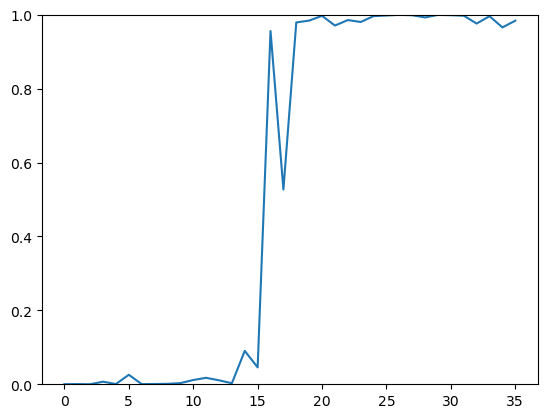

In [74]:
import matplotlib.pyplot as plt
plt.ylim(0,1)
plt.plot(death_probabilities)

In [31]:
import os

file_list = []

for f in os.listdir(r"C:\rkka_Projects\cell_death_v1\Data\test"):
    if f.endswith('.png'):
        file_list.append(f)

In [48]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch_tomogram_dataset.utils import calculate_edge_mean_2d
from torch_tomogram_dataset.transforms import augmentation_transform_2d
from PIL import Image

class Cata(Dataset):
    def __init__(self, root_dir, transform=None, augmentation=False):
        super().__init__()
        
        self.root_dir = root_dir
        self.augmentation = augmentation
        self.transform = transform
        self.samples = []
        self.labels = []
        
        states = ['live', 'dead']
        for label, state in enumerate(states):
            path = os.path.join(self.root_dir, state)
            for file in os.listdir(path):
                if file.endswith('.png'):
                    self.samples.append(os.path.join(path, file))
                    self.labels.append(label)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        image = Image.open(self.samples[idx]).convert('L')
        image = np.array(image)
        image = torch.from_numpy(image)
        label = self.labels[idx]
        
        if transform is not None:
            image = transform(image)
        
        # Rotation with edge mean filling
        if self.augmentation:
            edge_mean = calculate_edge_mean_2d(image_tensor)
            image_tensor = augmentation_transform_2d(image_tensor)
            image_tensor[image_tensor==0] = edge_mean
        
        return image, label